
# Milvus on Zilliz Cloud

This notebook shows **how to connect directly to a cloud‑hosted Milvus database (Zilliz Cloud)** and perform:

- Connection & authentication
- Collection inspection
- CRUD operations
- Vector similarity search
- Visual exploration of embeddings (2D)

Designed for **teaching Milvus concepts**, not local Docker setups.



## 1 Install & Import Dependencies


In [ ]:
%pip install pymilvus

In [ ]:

%pip install numpy matplotlib


## 2 Connect to Zilliz Cloud (Milvus)



In [ ]:
import os
from dotenv import load_dotenv
# from pymilvus import connections

# # If using Docker standalone Milvus
# connections.connect("default", host="127.0.0.1", port="19530")

from pymilvus import connections

load_dotenv(override=True, dotenv_path="../.env.local")

milvus_uri = os.getenv("MILVUS_URI")
milvus_token = os.getenv("MILVUS_API_KEY")


connections.connect(
    alias="default",
    uri=milvus_uri,
    token=milvus_token
)

print("Connected to Milvus on Zilliz Cloud")



## 3 Inspect Collections


In [31]:

from pymilvus import utility

utility.list_collections()


['demo_collection', 'policy_docs_collection', 'test_collection']


## 4 Load & Inspect a Collection


In [ ]:

from pymilvus import Collection

# Collection is same as a Table in traditional databases
collection = Collection("demo_collection")
collection.load()

collection.schema


{'auto_id': True, 'description': 'demo_collection', 'fields': [{'name': 'id', 'description': 'The Primary Key', 'type': <DataType.INT64: 5>, 'is_primary': True, 'auto_id': True}, {'name': 'vector', 'description': '', 'type': <DataType.FLOAT_VECTOR: 101>, 'params': {'dim': 4}}, {'name': 'title', 'description': '', 'type': <DataType.VARCHAR: 21>, 'params': {'max_length': 200}}], 'enable_dynamic_field': True, 'enable_namespace': False}


## 5 Read Data (Query)

Query a few rows to see **raw stored data**


In [ ]:

results = collection.query(
    expr="id >= 0",
    
    output_fields=["id", "title", "embedding"],
    limit=5
)
# select id, title, embedding from demo_collection where id >= 0 limit 5
results


In [35]:
results = collection.query(
    expr="id in [463705163763347400, 463705164234735154] AND title == 'Deep Learning (Updated)'",
    
    output_fields=["id", "title", "embedding"],
    limit=5
)
# select id, title, embedding from demo_collection where id >= 0 limit 5
results


data: ["{'id': 463705164234735154, 'title': 'Deep Learning (Updated)'}"], extra_info: {'cost': 6, 'scanned_remote_bytes': 0, 'scanned_total_bytes': 6291456, 'cache_hit_ratio': 1.0}


## 6 Insert (CREATE)

Insert a new vector record


In [37]:
import numpy as np

data = [
    [[.3456, .2345, .1234, .5678]],            # vector FIRST
    ["Milvus makes vector search scalable"]     # title SECOND
]

collection.insert(data)
collection.flush()



## 7 Update (DELETE + INSERT pattern)

Milvus does not support in‑place updates.


In [41]:
# collection.delete(expr="id == 463705163763347399")
# collection.flush()

updated_data = [
    [463705165204270561],  # ← list of IDs (1 row)
    [
        [0.7000895, 0.022113776, 0.48144588, 0.23203984]
    ],  # ← list of vectors (1 row)
    [
        "Next.JS for Beginners - Updated"
    ]   # ← list of titles (1 row)
]

result = collection.upsert(updated_data)
collection.flush()

new_id = result.primary_keys[0]
print(f"Record updated. New ID generated: {new_id}")


Record updated. New ID generated: 463705165204274835



## 8 Delete


In [ ]:

collection.delete(expr="id == 463705164234735372")
collection.flush()

print("Record deleted")



Record deleted


data: [], extra_info: {'cost': 1}

In [ ]:

results = collection.query(
    expr="id == 463705164234754808",
    output_fields=[ "title", "vector"],
    # output_fields=["*"],
    limit=5
)

results


data: ["{'id': 463705164234754808, 'vector': [0.7000895142555237, 0.022113775834441185, 0.48144587874412537, 0.23203983902931213], 'title': 'Deep Learning (Updated)'}"], extra_info: {'cost': 6, 'scanned_remote_bytes': 0, 'scanned_total_bytes': 5242880, 'cache_hit_ratio': 1.0}


## 9 Vector Similarity Search


In [ ]:
query_vector = [0.4670895, 0.343513776, 0.22224588, 0.113984]
print(f"Query Vector: {query_vector}")
search_results = collection.search(
    data=[query_vector],
    anns_field="vector",
    param={"metric_type": "COSINE", "params": {"nprobe": 10}},
    limit=1,
    output_fields=["id","title"]
)
print(f"Search Results: {search_results}")

for hit in search_results[0]:
    print(f"title={hit.entity.get('title')}")


Query Vector: [0.4670895, 0.343513776, 0.22224588, 0.113984]
Search Results: data: [[{'id': 463705164369185718, 'distance': 0.9639728665351868, 'entity': {'title': 'Milvus makes vector search scalable', 'id': 463705164369185718}}]],{'cost': 6, 'scanned_remote_bytes': 0, 'scanned_total_bytes': 4194304, 'cache_hit_ratio': 1.0}
title=Milvus makes vector search scalable



## 10 Visualizing Embeddings (PCA)

This helps students **see vector similarity**


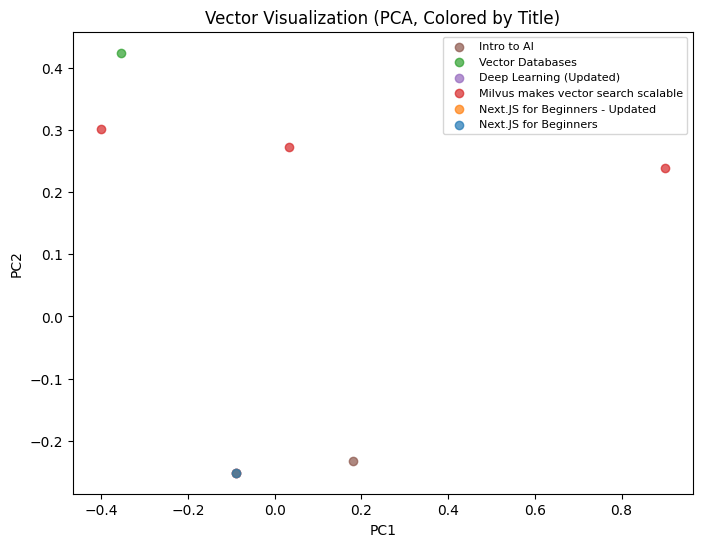

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1️⃣ Pull vectors + titles from Milvus
data = collection.query(
    expr="id >= 0",
    output_fields=["vector", "title"],
    limit=100
)

vectors = np.array([d["vector"] for d in data])
titles = [d["title"] for d in data]

# 2️⃣ Reduce vectors to 2D using PCA
pca = PCA(n_components=2)
reduced = pca.fit_transform(vectors)

# 3️⃣ Color points by title
unique_titles = list(set(titles))
colors = plt.cm.tab10(range(len(unique_titles)))
color_map = dict(zip(unique_titles, colors))

plt.figure(figsize=(8,6))

for i, title in enumerate(titles):
    plt.scatter(
        reduced[i, 0],
        reduced[i, 1],
        color=color_map[title],
        alpha=0.7,
        label=title
    )

# Remove duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize=8)

plt.title("Vector Visualization (PCA, Colored by Title)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
